## Trust Region updates for Generalized Advantage Estimation
One of the issues that we ran into last time, was that the GAE tended to drastically shift the approximation of the value function when applied at each iteration, and even when trained more sparsely, tended to get solutions that were not exactly optimal. One way to stablize this proccess is to add an extra constraint to the Loss function being minimized during value function estimation to include a measure of divergence between the current and previous value function estimates for each state. In order to do this we are going to need to create another loss function for VF estimation, and update our current VF training function, as well as the loss function class for the policy optimization (as we will have to carry along the old value function at each iteration). Again we include the the following line below in order to get all the code we have worked on thus far.

In [240]:
%run running_codebase.ipynb

from copy import deepcopy

In [241]:
class VALUE_FUNCTION_LOSS(torch.nn.Module):
    
    def __init__(self, epsilon, beta):
        super(VALUE_FUNCTION_LOSS, self).__init__()
        self.beta = beta
        self.epsilon = epsilon
        
    def forward(self, previous_VF_seq, current_VF_seq, empirical_VF_seq):
        sigma_sqr = torch.dot(current_VF_seq - empirical_VF_seq, current_VF_seq - empirical_VF_seq)
        primary = torch.dot(current_VF_seq - empirical_VF_seq, current_VF_seq - empirical_VF_seq) 
        penalization = self.beta * (1/(2*sigma_sqr)*torch.dot(current_VF_seq - previous_VF_seq, current_VF_seq - previous_VF_seq) - self.epsilon)
        return primary + penalization

In [242]:
def train_value_function(states, exp_cumu_rewards, state_size = 2, \
                         current_value_function = None, previous_value_function = None):
    
    # initialize value function
    if current_value_function == None and previous_value_function == None:
        previous_value_function = BaselineModel(state_size, 1)
        current_value_function = BaselineModel(state_size, 1)
    elif current_value_function == None:
        current_value_function = previous_value_function
    else:
        pass

    # set max iterations for training
    epochs = 10**3
    
    # set langrangian multiplier and epsilon parameter (distribtion distance)
    beta = 1
    epsilon = 10
    
    # train to approximate average reward at state
    loss_func = VALUE_FUNCTION_LOSS(epsilon, beta)
    
    # define optimizer and learning rate
    l_rate = 0.1
    optimizer = torch.optim.Adam(current_value_function.parameters(), lr = l_rate)
    
    # train value function model
    for epoch in range(epochs):
        
        # get predictions
        previous_pred_cumu_rewards = torch.zeros([len(exp_cumu_rewards)])
        current_pred_cumu_rewards = torch.zeros([len(exp_cumu_rewards)])
        for sample in range(exp_cumu_rewards.size()[0]):
            # now we have to look at the current + prev value function
            previous_pred_cumu_rewards[sample] = previous_value_function(states[sample, :])
            current_pred_cumu_rewards[sample] = current_value_function(states[sample, :])
        
        # zero out variable gradients
        optimizer.zero_grad()
      
        # create computation graph for loss
        loss = loss_func(previous_pred_cumu_rewards, current_pred_cumu_rewards, exp_cumu_rewards)
    
        # apply back prop
        loss.backward(retain_graph=True) 
        
        # update the parameters
        optimizer.step() 
        
#         # print info
#         if epoch%100==0:
#             print(np.floor(100*epoch/epochs), "% percent complete", ", current loss", loss, end='\r',flush=False)
    
    # return
    return loss, current_value_function, previous_value_function

In [243]:
def train_policy(epochs, grid, samples, T, discount, bv_tradeoff, alpha, sd, VF_freq):

    # initialize policy
    policy_obj = POLICY(2, 5)
    
    # set optimization info
    optimizer = torch.optim.Adam(policy_obj.parameters(), lr=1e-2)
    loss_func = POLICY_GRADIENT_LOSS(alpha, discount, bv_tradeoff, sd,  T, samples)
    
    # plotting storage (loss and cumulative reward)
    loss_per_iteration = torch.zeros((epochs))
    cr_per_iteration = torch.zeros((epochs))
    
    # train model
    for epoch in range(epochs):
        
        # set the probability of picking a random move
        randomness = (10 + epoch)/(1+epoch)**2
        
        # set policy
        policy = lambda state: policy_obj.sample_action(state, randomness)
        log_prob = lambda state, action: policy_obj.logprob_action(state, action)
        
        # get sampled trajectories
        state_tensor, action_tensor, reward_tensor = grid.simulate_trajectory(T, samples, policy)
        
        # loss objective being minimized
        if epoch%VF_freq==0:
            if epoch == 0:
                loss, value_function = loss_func(log_prob, state_tensor, action_tensor, reward_tensor)
                prev_value_function = value_function
            else:
                prev_value_function = value_function
                loss, value_function = loss_func(log_prob, state_tensor, action_tensor, reward_tensor, None, prev_value_function)
        else:
            loss, _ = loss_func(log_prob, state_tensor, action_tensor, reward_tensor, value_function, None)
            
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backprop through computation graph
        loss.backward()
        
        # step optimizer
        optimizer.step()
        
        # print loss
        print("current loss at iteration: " + str(epoch/epochs) + ", with loss: " + str(loss) + ", ends in state: " + str(state_tensor[:,-1,0]), end='\r', flush=False)
        
        # store loss
        loss_per_iteration[epoch] = loss
        cr_per_iteration[epoch] = sum(sum(reward_tensor))/samples
        
    # print a trajectory
    state_tensor, action_tensor, reward_tensor = grid.simulate_trajectory(T, samples, policy)
    for time in range(T):
        print(state_tensor[:,time,0], reward_tensor[time,0], action_tensor[time,0], end='\r')

    # return policy
    return policy, loss_per_iteration, cr_per_iteration

In [244]:
class POLICY_GRADIENT_LOSS(torch.nn.Module):
    """ MAXIMUM ENTROPY POLICY GRADIENTS LOSS FUNCTION """
    def __init__(self, alpha, discount, bv_tradeoff, sd, trajectory_length, simulations):
        super(POLICY_GRADIENT_LOSS, self).__init__()
        self.sd = sd
        self.alpha = alpha
        self.discount = discount
        self.trajectory_length = trajectory_length
        self.simulations = simulations
        self.bv_tradeoff = bv_tradeoff
        self.value_function = None
        self.prev_value_function = None
        
    def generate_value_function(self, sampled_values, sampled_states, \
                                value_function = None, prev_value_function = None):
        """ TRAIN VALUE FUNCTION """
        state_size = len(sampled_states[0,:])
        if value_function == None and prev_value_function == None:
            _, self.value_function, self.prev_value_function = train_value_function(sampled_states, sampled_values, state_size)
            return self.value_function
        else:
            _, self.value_function, self.prev_value_function = train_value_function(sampled_states, sampled_values, state_size, \
                                                            value_function, prev_value_function)
            return self.value_function
        
    def Advantage_estimator(self, logliklihood_tensor, trajectories_state_tensor, \
                            trajectories_action_tensor, trajectories_reward_tensor, \
                            value_function):
        """ COMPUTES ROLL OUT WITH MAX ENT REGULARIZATION """
        # initialize cumulative running average for states ahead
        advantage = torch.zeros([self.trajectory_length, self.simulations])
        delta_t = torch.zeros([self.trajectory_length, self.simulations])
        # calculate last delta term
        delta_t[self.trajectory_length-1,:] = trajectories_reward_tensor[self.trajectory_length-1,:] \
                                                         + self.alpha*logliklihood_tensor[self.trajectory_length-1,:]
        # calculate last advantage value
        advantage[self.trajectory_length-1,:] = delta_t[self.trajectory_length-1,:]
        # compute other delta values
        for time in reversed(range(0, self.trajectory_length-1)):
            for simulation in range(self.simulations):
                delta_t[time,simulation] = trajectories_reward_tensor[time, simulation] + self.alpha * logliklihood_tensor[time,simulation] \
                                    - self.value_function(trajectories_state_tensor[:,time,simulation]) \
                                    + self.discount * self.value_function(trajectories_state_tensor[:,time+1,simulation]) 
                advantage[time,simulation] = delta_t[time,simulation] + self.discount * self.bv_tradeoff * advantage[time+1,simulation]
        
        # detach cumulative reward from computation graph
        advantage = advantage.detach()
        
        # return everything
        return advantage

    def forward(self, model_liklihood, trajectories_state_tensor, trajectories_action_tensor, \
                trajectories_reward_tensor, value_function = None, prev_value_function = None):
        """ CALCULATE LOG LIKLIHOOD OF TRAJECTORIES """
        # initialize tensor for log liklihood stuff
        logliklihood_tensor = torch.zeros([self.trajectory_length, self.simulations])
        # initialize tensors for training a value function
        cumulative_reward = torch.zeros([self.trajectory_length+1, self.simulations])
        sampled_values = torch.zeros([self.trajectory_length * self.simulations])
        sampled_states = torch.zeros([len(trajectories_state_tensor[:,0,0]), self.trajectory_length * self.simulations])
        # append extra value to account for the end of the trajectory
        cumulative_reward[self.trajectory_length,:] = trajectories_reward_tensor[self.trajectory_length-1,:] \
                                                         + self.alpha*logliklihood_tensor[self.trajectory_length-1,:]
        # generate tensor for log liklihood and empirical value function samples 
        for time in reversed(range(self.trajectory_length)):
            for simulation in range(self.simulations):
                # logliklihood [simulation #, value, time step]
                logliklihood_tensor[time,simulation] = model_liklihood(trajectories_state_tensor[:,time,simulation],\
                                                                       trajectories_action_tensor[time,simulation])
            # cumulative reward
            cumulative_reward[time,:] = trajectories_reward_tensor[time, :] + self.alpha * logliklihood_tensor[time,:] \
                                        + cumulative_reward[time+1,:]
            # value function info
            sampled_values[time*simulations:(time+1)*simulations] = cumulative_reward[time,:]
            sampled_states[:,time*simulations:(time+1)*simulations] = trajectories_state_tensor[:,time,:]
        
        """ TRAIN VALUE FUNCTION """
        if value_function == None and prev_value_function == None:
            value_function = self.generate_value_function(sampled_values, sampled_states.transpose(0, 1))
        elif value_function == None:
            value_function = self.generate_value_function(sampled_values, sampled_states.transpose(0, 1),\
                                                          None, prev_value_function)
        elif prev_value_function == None:
            value_function = value_function
        else:
            value_function = value_function
          
        """ CALCULATE ADVANTAGE REGULARIZED BY ENTROPY """
        A_hat = self.Advantage_estimator(logliklihood_tensor, trajectories_state_tensor, trajectories_action_tensor, \
                                         trajectories_reward_tensor, value_function)
        
        """ CALCULATE POLICY GRADIENT OBJECTIVE """
        # initialize expectation tensor
        expectation = 0
        
        # calculate instance of expectation for timestep then calc sample mean
        for time in range(self.trajectory_length):
            expectation += torch.dot(A_hat[time,:], logliklihood_tensor[time,:])/self.simulations    
        
        # sum accross time
        expectation = -1 * torch.sum(expectation)/self.trajectory_length

        """ RETURN """
        return expectation, value_function

In [254]:
pre_determined_grid = [[-1,   -1,  -1,   -10,   -1, 10**5],
                       [-100, -1,  -10,  -1,    -10,  -10],
                       [-100, -1,  -100, -10,   -10,  -10],
                       [-1,   -1,  -100, -100,  -10,   -1],
                       [-10,  -1,  -100, -100,  -100,  -1],
                       [-1,   -1,  -100, -100,  -100,  -100]]

# hyper parameters
iterations = 500
Time = 50
simulations = 10
discount = 0.99
bv_tradeoff = 0.99
VF_freq = 100
alpha = 1
sd = 1

#initializations
start_state = [5,0]
policy_obj = POLICY(2, 5)
policy = lambda state: policy_obj.sample(state)
grid = GRID_WORLD(pre_determined_grid, start_state)
policy, loss_per_iteration, cr_per_iteration = train_policy(iterations, grid, simulations, Time, discount, bv_tradeoff, alpha, sd, VF_freq)

## Now lets plot everything 

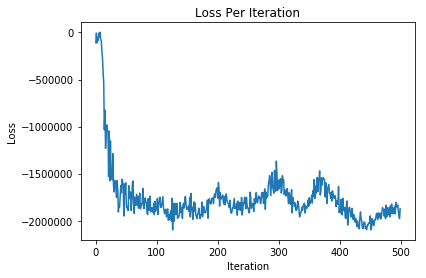

In [255]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(iterations)], -1*loss_per_iteration.detach().numpy())
plt.title('Loss Per Iteration')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

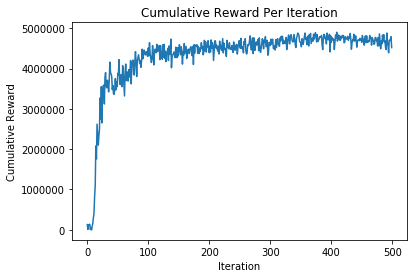

In [256]:
plt.plot([i for i in range(iterations)], cr_per_iteration.numpy())
plt.title('Cumulative Reward Per Iteration')
plt.ylabel('Cumulative Reward')
plt.xlabel('Iteration')
plt.show()

In [257]:
T = 50
samples = 1
state_tensor, action_tensor, reward_tensor = grid.simulate_trajectory(T, samples, policy)
for time in range(25):
    print(state_tensor[:,time,0], reward_tensor[time,0], action_tensor[time,0])

tensor([5., 0.]) tensor(-1.) tensor(3.)
tensor([5., 1.]) tensor(-1.) tensor(1.)
tensor([4., 1.]) tensor(-1.) tensor(3.)
tensor([4., 2.]) tensor(-100.) tensor(3.)
tensor([4., 3.]) tensor(-100.) tensor(1.)
tensor([3., 3.]) tensor(-100.) tensor(1.)
tensor([2., 3.]) tensor(-10.) tensor(3.)
tensor([2., 4.]) tensor(-10.) tensor(1.)
tensor([1., 4.]) tensor(-10.) tensor(1.)
tensor([0., 4.]) tensor(-1.) tensor(0.)
tensor([0., 4.]) tensor(-1.) tensor(0.)
tensor([0., 4.]) tensor(-1.) tensor(2.)
tensor([1., 4.]) tensor(-10.) tensor(0.)
tensor([1., 4.]) tensor(-10.) tensor(3.)
tensor([1., 5.]) tensor(-10.) tensor(1.)
tensor([0., 5.]) tensor(100000.) tensor(1.)
tensor([0., 5.]) tensor(100000.) tensor(0.)
tensor([0., 5.]) tensor(100000.) tensor(0.)
tensor([0., 5.]) tensor(100000.) tensor(0.)
tensor([0., 5.]) tensor(100000.) tensor(0.)
tensor([0., 5.]) tensor(100000.) tensor(0.)
tensor([0., 5.]) tensor(100000.) tensor(0.)
tensor([0., 5.]) tensor(100000.) tensor(3.)
tensor([0., 5.]) tensor(100000.) ten